In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

import os

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle

import xspec as x

#### For eROSITA 30.0x30.0 field we take all clusters within the lightcone (flag=0) with $M_{500}> 10^{14} M_{\odot}$:

In [2]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


ihal: HaloID

x_pix,y_pix: position of the cluster in the Lightcone [0..1]. Multiply by 30
             degree to get position in sky.
             
z_pix:       relative position within the slice [0..1]

Note on x_pix,y_pix,z_pix: Objects are included if their size overlaps with the
                           Lightcone, therefore these central positions can be
                           slightly outside the Lightcone. The value of flag 
                           (last column) indicates if a object is fully within
                           the Lightcone (0) or if it is only partially within
                           the Lightcone (1).
                           
Rrel:        relative size of the virial radius (TopHat). Multiply by 30 degree
             to obtain the size of the virial radius on the sky.
             
Mvir         Nvir (TopHat) in Msol/h

z_true:      real redshift of the object (use this for distances)

z_obs:       redshift as spectroscopicly observed (use this as observed redshift)

M500:        M500 (critical) in Msol/h

R500:        R500 (critical) in kpc/h

Mstar500:    Stellar mass within R500 (critical) in Msol/h

Mgas500:     Gas mass within R500 (critical) in Msol/h

T500:        Mass weighted temperature within R500 (critical) in keV

Lx500:       Bolometric X-Ray luminosity within R500 (critical) in 1e44 erg/s

Ysz500:      ComptonY within R500 (critical)

M200:        M200 (critical) in Msol/h

R200         R200 (critical) in kpc/h

flag:        Indication if object is fully (=0) or only partial (=1) within the
             Lightcone.

In [3]:
len(clusters), min(clusters["z_true"]), max(clusters["z_true"])

(84, 0.034098784, 0.19434476)

#### ZuHone's figure 1:

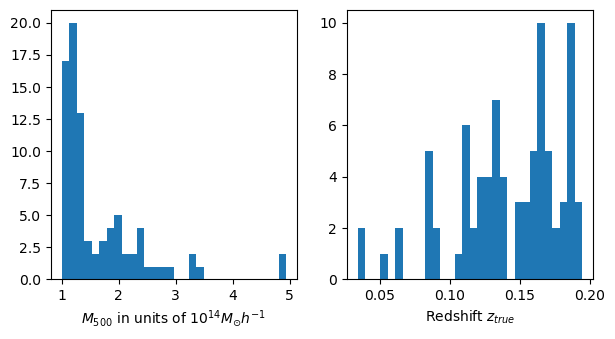

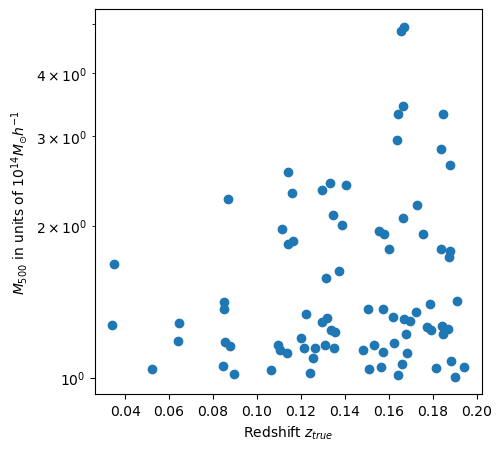

In [96]:
plt.figure(figsize = (7,3.5))

plt.subplot(121)
plt.hist(clusters["M500"]/10**14, bins=30, histtype='stepfilled')
plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

plt.subplot(122)
plt.hist(clusters["z_true"], bins=30, histtype='stepfilled')
plt.xlabel("Redshift $z_{true}$")

plt.show()


plt.figure(figsize = (5,5))

plt.scatter(clusters["z_true"], clusters["M500"]/10**14)
#plt.scatter(clusters["z_obs"], clusters["M500"]/10**14)
plt.xlabel("Redshift $z_{true}$")
plt.ylabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.yscale("log")

plt.show()

The redshift used in computing distances $z_{true}$ is obtained by computing the offset of the cluster center from the center of the slice, and the redshift used in fitting spectra $z_{obs}$ also takes into account the peculiar velocity of the cluster within the slice. 

#### Plotting all these clusters in 2D:

In [5]:
x_c = 30*clusters["x_pix"].values    # deg
y_c = 30*clusters["y_pix"].values    # deg
#z_c = clusters["z_pix"]              # relative position within the slice [0...1]
z_c = clusters["z_true"]

r_500 = clusters["R500"].values        # kpc/h
redshifts = clusters["z_true"].values

h = 0.704
Omega_M = 0.272
D_A = FlatLambdaCDM(H0=100*h, Om0=Omega_M).angular_diameter_distance(redshifts) # Mpc

r_500_rescaled = [num/denom*180/np.pi for num, denom in zip(r_500*h, 1000*D_A.value)]  # degrees

R_vir = 30*clusters["Rrel"].values

#### Example from `run_phox_cluster_erosita_lightcone.cmd` as motivator to take Rrel*30 as $R_{500}$:

In [6]:
clusters.iloc[28]["x_pix"]*30-5, clusters.iloc[28]["y_pix"]*30-5, clusters.iloc[28]["Rrel"]*30

(17.6464642, 18.0108214, 0.190842306)

#### Please note that $R_{rel}$ (virial radius) is taken as $R_{500}$, which may be bad decision!

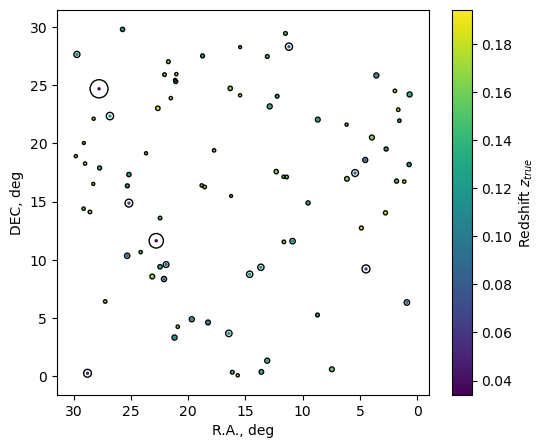

In [7]:
plt.figure(figsize=(6,5))#, layout='constrained')

plt.scatter(x_c, y_c, c=redshifts, cmap='viridis', s=2)

for xc, yc, r in zip(x_c, y_c, R_vir):
    plt.gca().add_patch( plt.Circle( (xc, yc), r, fill = False) )
    
plt.gca().invert_xaxis()
    
plt.colorbar(label="Redshift $z_{true}$")

plt.xlabel("R.A., deg")
plt.ylabel("DEC, deg")

plt.show()

#### Adding slices from Phox and drawing in 3D:

In [8]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


#### ...considering `geometry.dat`...

In [9]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)
geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


#### (there are no clusters of interest in snap number 144)

snapNr:   Snap Number

ztab:     redshift of the simulation output used for the slice

zslice:   mean redshift of the slice (e.g. redshift corresponding to the mean popper distance of the slice)

z_start:  minimum redshift of the slice

z_end:    maximum redshift of the slice

x0,y0,z0: Center position of the box used

depth:    proper distance in z direction of the slice in Mpc

width:    proper distance of the field of view in Mpc

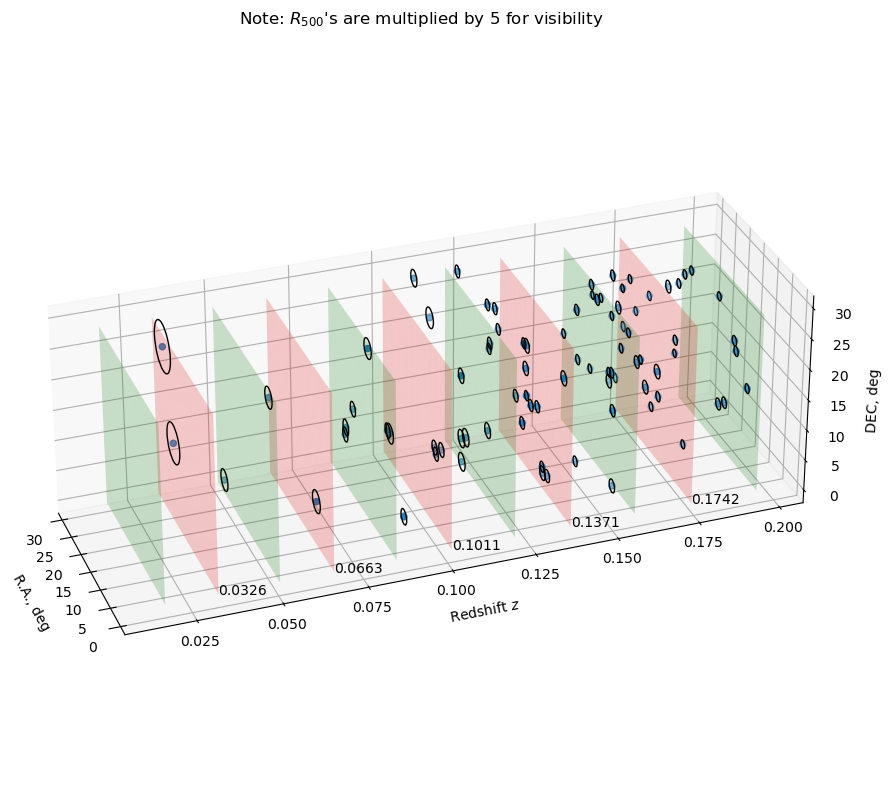

In [10]:
fig = plt.figure(figsize=(10,8), layout="constrained")

ax = fig.add_subplot(projection='3d')

ax.scatter(x_c, redshifts, zs=y_c, zdir='z', cmap='viridis')

for xc, yc, r, rdsh in zip(x_c, y_c, R_vir, redshifts):
    p = Circle( (xc, yc), r*5, fill = False)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=rdsh, zdir="y")

ax.set_xlabel("R.A., deg")
ax.set_ylabel('\n \n Redshift $z$')
ax.set_zlabel("DEC, deg")

ax.invert_xaxis()

xx, yy = np.meshgrid(range(30), range(30))
for rdsh in phlists_redshifts:
    ax.plot_surface(xx, rdsh, yy, alpha=0.2, color='red')
    ax.text(0, rdsh, 0, f"{rdsh:.4f}")
    
xx, yy = np.meshgrid(range(30), range(30))
for rdsh in geometry["z_end"]:
    ax.plot_surface(xx, rdsh, yy, alpha=0.2, color='green')

ax.view_init(elev=30., azim=-20)

ax.set_box_aspect(aspect = (1,3,1), zoom = 1)

ax.set_title("Note: $R_{500}$\'s are multiplied by 5 for visibility")

plt.show()

Green is `z_end`, red -- `z_slice`, blue dots are clusters. Black cirles are $R_{500}$'s multiplied by 5 for visibility and comparison.

#### Binning clusters between slices (keys = halo index (not ihal!), values = redshifts and snap ID's of slices):

In [11]:
binned_clusters = {}
    
for ind in clusters.index:
    
    cl = clusters.loc[ind]
    
    zxcvbn = cl["z_true"]
    
    #print(ind, zxcvbn)
    
    for i in range(0, len(phlists_redshifts)):
        
        #print(zxcvbn, phlists_redshifts[i])
    
        if zxcvbn > phlists_redshifts[i]:
            
            binned_clusters[ind] = phlists_redshifts[i], phlists[i][7:10]
            
            #print(zxcvbn, phlists_redshifts[i], binned_clusters[ind])
            
            break
                
binned_clusters

{171: (0.13708140389145, '128'),
 187: (0.13708140389145, '128'),
 350: (0.13708140389145, '128'),
 820: (0.13708140389145, '128'),
 1245: (0.13708140389145, '128'),
 1380: (0.13708140389145, '128'),
 1707: (0.13708140389145, '128'),
 1819: (0.13708140389145, '128'),
 1838: (0.13708140389145, '128'),
 2270: (0.13708140389145, '128'),
 2386: (0.13708140389145, '128'),
 2421: (0.13708140389145, '128'),
 2471: (0.13708140389145, '128'),
 2593: (0.13708140389145, '128'),
 2603: (0.13708140389145, '128'),
 2815: (0.13708140389145, '128'),
 2904: (0.13708140389145, '128'),
 3155: (0.13708140389145, '128'),
 3886: (0.13708140389145, '128'),
 3985: (0.13708140389145, '128'),
 4613: (0.174192889973847, '124'),
 4967: (0.174192889973847, '124'),
 5326: (0.174192889973847, '124'),
 5443: (0.174192889973847, '124'),
 6001: (0.174192889973847, '124'),
 6496: (0.174192889973847, '124'),
 6529: (0.174192889973847, '124'),
 6582: (0.174192889973847, '124'),
 6695: (0.174192889973847, '124'),
 6740: (0

In [12]:
#binned_clusters = {}
    
#for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
        
    #print(borders)
    
#    for ind in clusters.index:

#       cl = clusters.loc[ind]

#        zxcvbn = cl["z_true"]

        #print(ind, zxcvbn)

#        if zxcvbn > borders[0] and zxcvbn < borders[1]:

#            binned_clusters[ind] = borders[2], borders[3]
                
#sorted(binned_clusters.items())

### TODO: 

Maybe its better to invert dictionary.

#### Binning clusters and checking if they are binned correctly

[0.032637492755919, 0.0663401914452304, 0.101142861718869, 0.13708140389145, 0.174192889973847, 0.2]


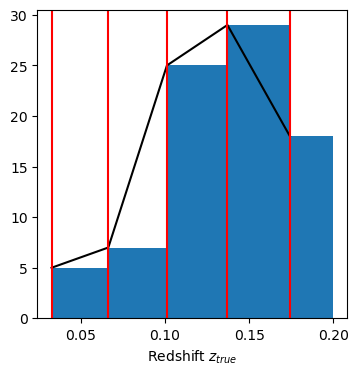

In [13]:
BINS = phlists_redshifts[::-1] + [0.2]

print(BINS)

plt.figure(figsize=(4,4))      
        
plt.hist(clusters["z_true"], bins=BINS, histtype='stepfilled')
plt.xlabel("Redshift $z_{true}$")

check = np.unique([a[0] for a in binned_clusters.values()], return_counts=True)[1] # if binned correctly
    
plt.plot(phlists_redshifts, check[::-1], color = 'black')

for rdsh in phlists_redshifts:
    plt.axvline(rdsh, color='red')

plt.show()

#### Facts

Programs distributed with HEASOFT are called “ftools”. If you want to know more about the parameters of an FTOOL, use the command fhelp ftoolname where “ftoolname” is the name of the FTOOL. To get a list of all available FTOOLS, use fhelp ftools.

`!fv ../data/eROSITA_30.0x30.0/Phox/phlist_140.fits`

`!fstruct ../data/eROSITA_30.0x30.0/Phox/phlist_140.fits`

#### Searching for photons from these clusters in photon lists. At first for one cluster. 

Steps: (1) take each snap, (2) choose only clusters related to this snap, (3) for each cluster choose only photons inside $R_{500}$.

In [14]:
snap_id = '140'

related_clusters = [i for i,j in binned_clusters.items() if j[1] == snap_id]
related_clusters

[18073, 18589, 18610, 19771, 19787]

In [15]:
current_cluster_num = related_clusters[4]

current_cluster_num

19787

In [16]:
current_cluster = clusters.loc[current_cluster_num]

current_cluster

ihal        8.300000e+01
x_pix       9.260318e-01
y_pix       8.229134e-01
z_pix       5.269593e-01
Rrel        2.605014e-02
Mvir        3.766600e+14
z_true      3.471737e-02
z_obs       3.399225e-02
M500        1.682650e+14
R500        6.769520e+02
Mstar500    5.699780e+12
Mgas500     1.686950e+13
T500        2.845680e+00
Lx500       9.512280e-01
Ysz500      3.578968e-06
M200        2.866160e+14
R200        1.097250e+03
flag        0.000000e+00
Name: 19787, dtype: float64

In [17]:
RA_c = current_cluster["x_pix"]*30-5
DEC_c = current_cluster["y_pix"]*30-5
R_vir = current_cluster["Rrel"]*30

R_500 = current_cluster["R500"]*0.704  # kpc
ztrue = current_cluster["z_true"]

D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(ztrue)*1000 # kpc

R_500_rescaled = R_500/D_A.value*180/np.pi

RA_c, DEC_c, R_vir, R_500_rescaled

(22.780954599999998, 19.6874032, 0.7815042299999999, 0.19248360419179314)

In [18]:
snap_id_str = binned_clusters[current_cluster_num][1]

In [19]:
hdul = fits.open("../data/eROSITA_30.0x30.0/Phox/phlist_"+snap_id+".fits")

SLICE = pd.DataFrame(hdul[2].data[:])

display(SLICE)

hdul.close()

,ENERGY,RA,DEC
0,0.165827,11.067711,10.758957
1,0.208517,1.776705,9.079003
2,0.154514,11.083459,10.756147
3,0.114760,8.337882,3.265597
4,0.114936,8.325741,3.270800
...,...,...,...
7268680,0.683254,-0.438296,24.351841
7268681,0.700846,-0.458125,24.322994
7268682,0.715961,-0.452658,24.334837
7268683,0.769633,-0.451354,24.328300


In [20]:
from astropy.table import Table

In [21]:
def extract_photons(ra_cl, dec_cl, R_cl, snapID):
    
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/phlist_"+snapID+".fits", hdu=2)
    
    SLICE = t.to_pandas()
    
    SLICE["check"]=np.where((SLICE["RA"]-ra_cl)**2+(SLICE["DEC"]-dec_cl)**2 <= R_cl**2, True, False)
    
    #display(SLICE)

    #if (ra_ph-x_cl)**2 + (dec_ph-y_cl)**2 <= r_cl**2:
     
    df = SLICE[SLICE['check'] == True]
    
    display(df)
    
    #df = df.drop("RA", axis=1)
    #df = df.drop("DEC", axis=1)
    
    return df.drop("check", axis=1)

    
dddfff = extract_photons(RA_c, DEC_c, R_vir, snap_id)

display(dddfff)

,ENERGY,RA,DEC,check
184796,0.232713,22.708536,19.498272,True
185726,0.252945,22.696968,20.356155,True
189203,0.196683,22.718506,19.820965,True
189204,0.103351,22.746279,19.735714,True
189205,0.115005,22.753073,19.729940,True
...,...,...,...,...
6339950,0.832822,22.417141,20.051483,True
6339951,0.902510,22.383286,20.031170,True
6339952,0.979782,22.383923,20.028664,True
6339953,0.980721,22.408531,20.045015,True


,ENERGY,RA,DEC
184796,0.232713,22.708536,19.498272
185726,0.252945,22.696968,20.356155
189203,0.196683,22.718506,19.820965
189204,0.103351,22.746279,19.735714
189205,0.115005,22.753073,19.729940
...,...,...,...
6339950,0.832822,22.417141,20.051483
6339951,0.902510,22.383286,20.031170
6339952,0.979782,22.383923,20.028664
6339953,0.980721,22.408531,20.045015


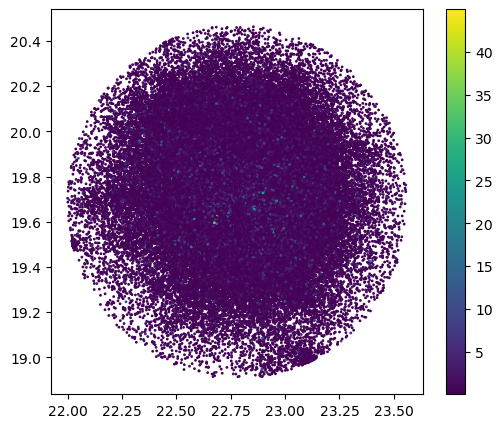

In [22]:
plt.figure(figsize=(6,5))

plt.scatter(dddfff["RA"], dddfff["DEC"], c=dddfff["ENERGY"], cmap='viridis', s=1)
plt.colorbar()
plt.show()

In [23]:
rrrr = fits.open('../erosita/erosita_pirmf_v20210719.rmf')
rrrr.info()
ff = rrrr[1].data
len(ff["E_MIN"])
#np.append(ff["E_MIN"], [12.0])

Filename: ../erosita/erosita_pirmf_v20210719.rmf
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  EBOUNDS       1 BinTableHDU     31   1024R x 3C   [I, E, E]   
  2  MATRIX        1 BinTableHDU     42   1024R x 6C   [E, E, I, 1PI(14), 1PI(14), 1PE(924)]   


1024

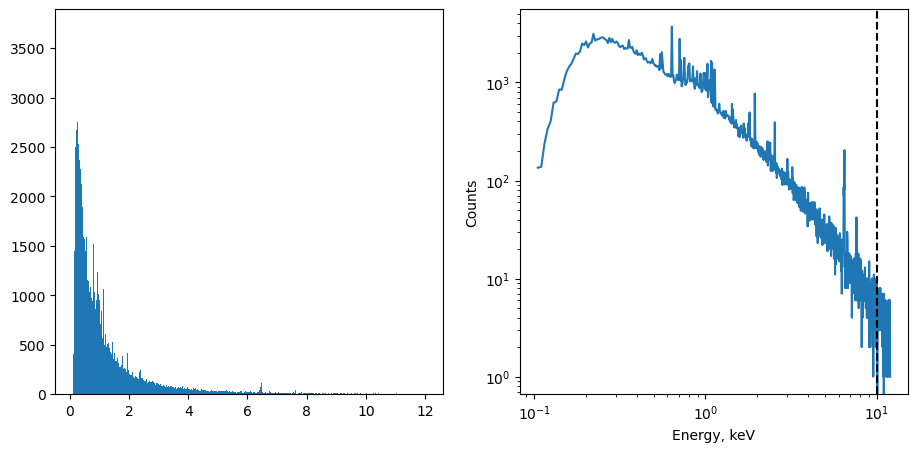

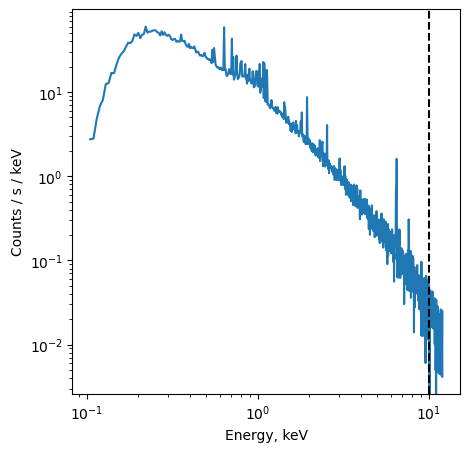

In [24]:
N_channels = 1024

#dummyrsp = np.linspace(0.1, 50.0, N_channels+1)
#dummyrsp = np.logspace(np.log10(0.1), np.log10(12.0), N_channels+1)
dummyrsp = np.append(ff["E_MIN"], [12.0])

plt.figure(figsize=(11, 5))

plt.subplot(121)
counts, energies, _ =  plt.hist(dddfff["ENERGY"], bins = dummyrsp)

plt.subplot(122)
plt.plot(energies[1:], counts)
plt.xscale('log')
plt.yscale('log')
plt.axvline(10.0, linestyle = '--', color='black')
plt.xlabel("Energy, keV")
plt.ylabel("Counts")

plt.figure(figsize=(5, 5))

plt.plot(energies[1:], [a/b/10000 for a, b in zip(counts, np.diff(dummyrsp))])
plt.xscale('log')
plt.yscale('log')
plt.axvline(10.0, linestyle = '--', color='black')
plt.xlabel("Energy, keV")
plt.ylabel("Counts / s / keV")

plt.show()

In [25]:
len(np.diff(energies))

1024

In [26]:
len(energies)

1025

In [27]:
#datfile = pd.DataFrame({"ENERG_LO":energies[:-1], "ENERG_HI":energies[1:], "COUNTS":counts})
datfile = pd.DataFrame({"COUNTS":counts})
datfile

,COUNTS
0,135.0
1,138.0
2,239.0
3,337.0
4,403.0
...,...
1019,1.0
1020,2.0
1021,5.0
1022,6.0


Writing to file:

In [28]:
datfile.to_csv(f'../data/eROSITA_30.0x30.0/photons/photons_'+str(current_cluster_num)+'.dat', index=True, header=False, sep=' ')

Reading from file:

In [29]:
#clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+')

XSPEC's “native” data format is the OGIP standard. See [XSPEC Data Formats](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node14.html). Useful tool: [ascii2pha](https://heasarc.gsfc.nasa.gov/docs/software/ftools/fhelp/ascii2pha.html) or [ftascii2pha](https://heasarc.gsfc.nasa.gov/lheasoft/help/ftascii2pha.html).

Also see here: [Appendix E: Associated Programs](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node322.html#AppendixPrograms). 

[SOXS](https://hea-www.cfa.harvard.edu/soxs/index.html) might be useful. And [HEASoftPY](https://heasarc.gsfc.nasa.gov/docs/software/heasoft/heasoftpy/). Maybe [profit](https://heasarc.gsfc.nasa.gov/docs/software/profit/manual/node16.html)?

Finally, [XSPEC Table Model Generator](https://github.com/mbursa/xspec-table-models/tree/main).

#### Writing to FITS-file

Primary header (HDU = Header Data Unit):

In [30]:
prihdr = fits.Header()

prihdr['COMMENT'] = "FITS (Flexible Image Transport System) format is defined in 'Astronomy  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"

#display(prihdr)

prihdu = fits.PrimaryHDU(header=prihdr)

display(prihdu.header)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H   

Table:

In [31]:
col0 = fits.Column(name='CHANNEL',  format='I', array = np.linspace(1,1024,1024))#datfile["ENERGIES"])
#col1 = fits.Column(name='E_MIN', format='E', array = datfile["ENERG_LO"], unit='keV')
#col2 = fits.Column(name='E_MAX', format='E', array = datfile["ENERG_HI"], unit='keV')
col3 = fits.Column(name='COUNTS',    format='I', array = datfile["COUNTS"], unit='COUNTS')

cols_spec = fits.ColDefs([col0, col3])
#cols_rmf  = fits.ColDefs([col0, col1, col2])

tbhdu_spec = fits.BinTableHDU.from_columns(cols_spec)
#tbhdu_rmf  = fits.BinTableHDU.from_columns(cols_rmf)

display(tbhdu_spec.data)
#display(tbhdu_rmf.data)

FITS_rec([(   1, 135), (   2, 138), (   3, 239), ..., (1022,   5),
          (1023,   6), (1024,   1)],
         dtype=(numpy.record, [('CHANNEL', '<i2'), ('COUNTS', '<i2')]))

Headers for table ([keywords](https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/docs/memos/cal_gen_92_002/cal_gen_92_002.html)):

Originally [here](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node6.html).

In [32]:
thdulist1 = fits.HDUList([prihdu, tbhdu_spec])
hdr1 = thdulist1[1].header

hdr1["EXTNAME"]  = ("SPECTRUM", 'the name (i.e. type) of the extension')
hdr1["TELESCOP"] = ("eROSITA", 'the "telescope" (i.e. mission/satellite name)')
hdr1["INSTRUME"] = ("TM1", 'the instrument/detector')
hdr1["FILTER"]   = ("NONE", 'the instrument filter in use (if any) ')
hdr1["EXPOSURE"] = ("10000", 'the integration time (in seconds) for the PHA data (assumed to be corrected for deadtime, data drop-outs etc. )')
hdr1["BACKFILE"] = ("NONE", 'the name of the corresponding background file (if any)')
hdr1["BACKSCAL"] = ("1", 'the background scaling factor (unless included as a column)')
hdr1["CORRFILE"] = ("NONE", 'the name of the corresponding correction file (if any)')
hdr1["CORRSCAL"] = ("1", 'the correction scaling factor')
hdr1["RESPFILE"] = ("NONE", 'the name of the corresponding (default) redistribution matrix file (RMF; see George et al. 1992a)')
hdr1["ANCRFILE"] = ("NONE", 'the name of the corresponding (default) ancillary response file (ARF; see George et al. 1992a)')
hdr1["AREASCAL"] = ("1", 'the area scaling factor (unless included as a column)')
hdr1["HDUCLASS"] = ("OGIP", 'should contain the string "OGIP" to indicate that this is an OGIP style file')
hdr1["HDUCLAS1"] = ("SPECTRUM", 'should contain the string "SPECTRUM" to indicate this is a spectrum')
hdr1["HDUVERS"]  = ("1.1.0", 'the version number of the format (this document describes version 1.2.1)')
hdr1["POISSERR"] = (True, 'whether Poissonian errors are appropriate to the data (see below)')
hdr1["CHANTYPE"] = ("PI", 'whether the channels used in the file have been corrected in anyway (see below)')
hdr1["DETCHANS"] = ("1024", 'the total number of detector channels available')

display(hdr1)

thdulist1.writeto('../data/eROSITA_30.0x30.0/photons/spectrum'+str(current_cluster_num)+'.pha', overwrite=True)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    4 / length of dimension 1                          
NAXIS2  =                 1024 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'CHANNEL '                                                            
TFORM1  = 'I       '                                                            
TTYPE2  = 'COUNTS  '                                                            
TFORM2  = 'I       '                                                            
TUNIT2  = 'COUNTS  '        

In [33]:
#thdulist2 = fits.HDUList([prihdu, tbhdu_rmf, mmmm])
#hdr2 = thdulist2[1].header

#hdr2["EXTNAME"]  = ("EBOUNDS", 'the name (i.e. type) of the extension')
#hdr2["TELESCOP"] = ("eROSITA", 'the "telescope" (i.e. mission/satellite name)')
#hdr2["INSTRUME"] = ("TM1", 'the instrument/detector')
#hdr2["FILTER"]   = ("NONE", 'the instrument filter in use (if any) ')
#hdr2["EXPOSURE"] = ("10000", 'the integration time (in seconds) for the PHA data (assumed to be corrected for deadtime, data drop-outs etc. )')
#hdr2["BACKFILE"] = ("NONE", 'the name of the corresponding background file (if any)')
#hdr2["BACKSCAL"] = ("1", 'the background scaling factor (unless included as a column)')
#hdr2["CORRFILE"] = ("NONE", 'the name of the corresponding correction file (if any)')
#hdr2["CORRSCAL"] = ("1", 'the correction scaling factor')
#hdr2["RESPFILE"] = ("NONE", 'the name of the corresponding (default) redistribution matrix file (RMF; see George et al. 1992a)')
#hdr2["ANCRFILE"] = ("NONE", 'the name of the corresponding (default) ancillary response file (ARF; see George et al. 1992a)')
#hdr2["AREASCAL"] = ("1", 'the area scaling factor (unless included as a column)')
#hdr2["HDUCLASS"] = ("OGIP", 'should contain the string "OGIP" to indicate that this is an OGIP style file')
#hdr2["HDUCLAS1"] = ("RESPONSE", 'should contain the string "SPECTRUM" to indicate this is a spectrum')
#hdr2["HDUCLAS2"] = ("EBOUNDS", 'should contain the string "SPECTRUM" to indicate this is a spectrum')
#hdr2["HDUVERS"]  = ("1.1.0", 'the version number of the format (this document describes version 1.2.1)')
#hdr2["POISSERR"] = ("TRUE", 'whether Poissonian errors are appropriate to the data (see below)')
#hdr2["CHANTYPE"] = ("PI", 'whether the channels used in the file have been corrected in anyway (see below)')
#hdr2["DETCHANS"] = ("1024", 'the total number of detector channels available')

#display(hdr2)

#thdulist2.writeto('../data/eROSITA_30.0x30.0/photons/my_rmf.fits', overwrite=True)

In [97]:
#fits.open('../data/eROSITA_30.0x30.0/photons/table.fits').info()
fits.open('../data/eROSITA_30.0x30.0/photons/spectrum'+str(current_cluster_num)+'.pha').info()

Filename: ../data/eROSITA_30.0x30.0/photons/spectrum19787.pha
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SPECTRUM      1 BinTableHDU     31   1024R x 2C   [I, I]   


In [35]:
#fits.open('../data/eROSITA_30.0x30.0/photons/my_rmf.fits').info()

In [98]:
x.AllData.clear()

#SPE = '../data/eROSITA_30.0x30.0/photons/spectrum'+str(current_cluster_num)+'.pha'

SPE = '../data/eROSITA_30.0x30.0/photons/spectrum'+str(current_cluster_num)+'.pha'

#RMF = '../data/eROSITA_30.0x30.0/photons/my_rmf.fits'

RMF = '../erosita/erosita_pirmf_v20210719.rmf'

ARF = '../erosita/tm1_arf_filter_000101v02.fits'

spectrum = x.Spectrum(SPE, respFile=RMF, arfFile=ARF)


1 spectrum  in use
 
Spectral Data File: ../data/eROSITA_30.0x30.0/photons/spectrum19787.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.298e+01 +/- 5.743e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.
Arf successfully loaded.
Spectrum 1  Spectral Data File: ../data/eROSITA_30.0x30.0/photons/spectrum19787.pha
Net count rate (cts/s) for Spectrum:1  3.298e+01 +/- 5.743e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_f

In [99]:
x.Plot.device = "/xs"

x.Plot.xAxis = "keV"

In [100]:
#rreesspp = spectrum.response

In [101]:
#rreesspp.setPars(1.05)
#rreesspp.show()

#rreesspp.gain.off()

#rreesspp.chanEnergies

In [102]:
#x.AllData.diagrsp()

In [103]:
#spectrum.response.show()
#.chanEnergies() = ",50,,log"

In [104]:
#[np.array(tbhdu_rmf.data)]
#mod.energies = spectrum.energies

In [105]:
#mod.energies

In [106]:
#spectrum.energies

In [107]:
spectrum.show()# = np.array(tbhdu_rmf.data)

Spectrum 1  Spectral Data File: ../data/eROSITA_30.0x30.0/photons/spectrum19787.pha
Net count rate (cts/s) for Spectrum:1  3.298e+01 +/- 5.743e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_filter_000101v02.fits

 Spectral data counts: 329774
 Model predicted rate: 0.0



In [110]:
x.AllData.notice("all")
#x.AllData.ignore("**-0.4 7.0-**")

  1024 channels (1,1024) noticed in spectrum #     1

All channels noticed


In [111]:
#x.AllData.ignore("bad")

In [112]:
x.AllModels.clear()

In [113]:
#mod = x.Model('pow+apec')

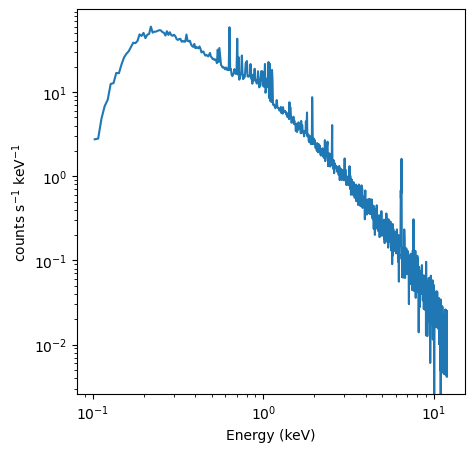

In [114]:
x.Plot("ldata")

xVals = x.Plot.x()
yVals = x.Plot.y()

plt.figure(figsize=(5, 5))

plt.plot(xVals, yVals)# np.multiply(np.multiply(xVals,xVals),yVals))
plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
#plt.title(x.Plot.labels()[2])

#plt.ylim(10**(-1), 10**2)

plt.show()

In [51]:
ens = x.AllData(1).energies

s_i = x.AllData(1).values

In [52]:
E_i = np.zeros(len(ens))

for i in ens:

    E_i[ens.index(i)] = (i[0]+i[1])/2

avE = np.dot(E_i, s_i)/sum(s_i)

avE

1.242985496736261

In [53]:
#%cd ../../multi-T/mixT

#%run -i 'utils/ave_lines.py'

#t_from_e(avE, 'SRG/eROSITA')

In [54]:
#x.Model("apec")

#fs = x.FakeitSettings(response = '../erosita/erosita_pirmf_v20210719.rmf', 
#                           arf = '../erosita/tm1_arf_open_000101v02.fits', 
#                    background = '', 
#                      exposure = 10000, 
#                    correction = '', 
#                  backExposure = '', 
#                      fileName = 'fakeit.pha')
#x.AllData.fakeit(nSpectra = 1, 
#                 settings = fs, 
#               applyStats = True,
#               filePrefix = "",
#                  noWrite = True)

In [55]:
#x.AllData.dummyrsp(lowE=0.1, highE=10.0, nBins=1024)

#x.Plot("mo lda")

In [117]:
mod = x.Model('apec')
#mod(1).frozen = True
#mod(1).values = 1e-2
#mod(3).frozen = False
#mod(3).values = 0.3
#mod(6).link = "4"
#mod(6).values = 0

zzzzz = current_cluster["z_true"]
mod(2).values = f"{zzzzz}"


Model apec<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            1.00000      frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared              2.173991e+08     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              2.173991e+08     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 1022 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared              2.907751e+06     using 1

In [118]:
x.AllModels.show()


Parameters defined:
Model apec<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   apec       kT         keV      1.00000      +/-  0.0          
   2    1   apec       Abundanc            3.47174E-02  frozen
   3    1   apec       Redshift            0.0          frozen
   4    1   apec       norm                1.00000      +/-  0.0          
________________________________________________________________________



In [58]:
#x.Fit.renorm('auto')
x.Fit.nIterations = 100
#x.Fit.query = 'yes'
#x.Fit.weight = 'standard'
#x.Fit.statMethod = 'chi'

x.Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl          2:kT        5:norm    6:PhoIndex        7:norm
33453.2      33407        -3      0.870224    0.00991689       1.60072     0.0341573
26455.6      44839.8      -4      0.730488    0.00403054       2.04485     0.0425121
25052.9      82255.9      -5      0.631968   0.000903284       2.16703     0.0425871
24831.3      46745.6      -6      0.287546   0.000158195       2.20608     0.0424010
24654.7      28192.2      -7      0.102198    0.00509740       2.16980     0.0411085
24437.2      9473.02       0      0.117948    0.00984385       2.17094     0.0411214
24165        3721.33       0      0.127072     0.0205401       2.15611     0.0408890
24062.8      9888.5        0      0.124561     0.0250885       2.13765     0.0406513
23972.2      6124.88       0      0.122245     0.0300329       2.12122     0.0404819
23891.8      4335.24       0      0.120160     0.0351954       2.10623     0.0403480
23848.2      3495.5

In [59]:
#x.Fit.steppar('1 0.1 5 10 4 0.000001 0.1 10')
#x.Plot("contour")

In [60]:
#x.AllModels.calcFlux('0.1 12.0')
#x.AllData(1).flux[0]

#x.Fit.error('1')

In [61]:
#x.AllData.removeDummyrsp()
#x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=1024, scaleType='lin')

In [62]:
#spectrum.response.chanEnergies
#spectrum.response.energies

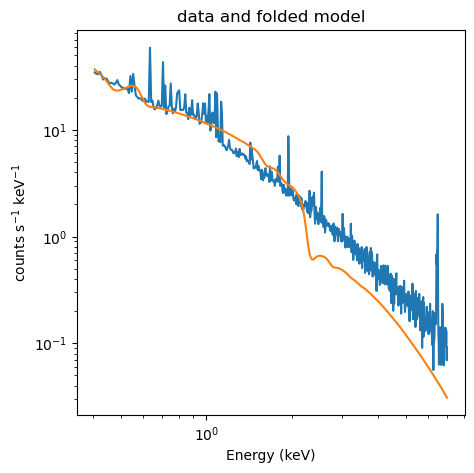

In [63]:
x.Plot("ldata")
xVals = x.Plot.x()
yVals = x.Plot.y()
modVals = x.Plot.model()

plt.figure(figsize=(5, 5))

plt.plot(xVals, yVals, xVals, modVals)
plt.xscale('log')
plt.yscale('log')

plt.xlabel(x.Plot.labels()[0])
plt.ylabel(x.Plot.labels()[1])
plt.title(x.Plot.labels()[2])

#plt.ylim(10**(-1), 10**2)

plt.show()

## Putting it al together:

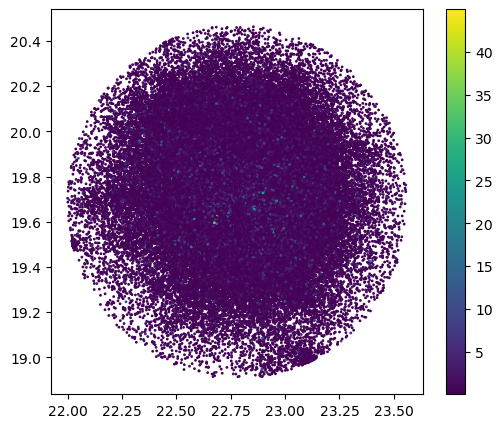

,ENERGY,RA,DEC
184796,0.232713,22.708536,19.498272
185726,0.252945,22.696968,20.356155
189203,0.196683,22.718506,19.820965
189204,0.103351,22.746279,19.735714
189205,0.115005,22.753073,19.729940
...,...,...,...
6339950,0.832822,22.417141,20.051483
6339951,0.902510,22.383286,20.031170
6339952,0.979782,22.383923,20.028664
6339953,0.980721,22.408531,20.045015


[ 0.1         0.10490672  0.10982741 ... 11.928325   11.952116
 11.976006  ]


In [82]:
%run -i 'utils/scripts.py'

cl_num = 19787

photons = extract_photons_from_cluster(cl_num, r = 'Rvir', draw=True)

display(photons)

erosita_binning = fits.open('../erosita/erosita_pirmf_v20210719.rmf')[1].data["E_MIN"]

print(erosita_binning)

In [94]:
%run -i 'utils/scripts.py'

create_spectrum(photons, REDSHIFT=clusters.loc[cl_num]["z_true"]) # or binned_clusters[19787][0] ???

Spectrum succesfully created



1 spectrum  in use
 
Spectral Data File: ../data/eROSITA_30.0x30.0/photons/spectrum19787.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.298e+01 +/- 5.743e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1024
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

Fit statistic  : Chi-Squared                296232.0     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                296232.0     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.0e+00 with 1020 degrees of freedom
 Current data and model not fit yet.
Arf successfully loaded.



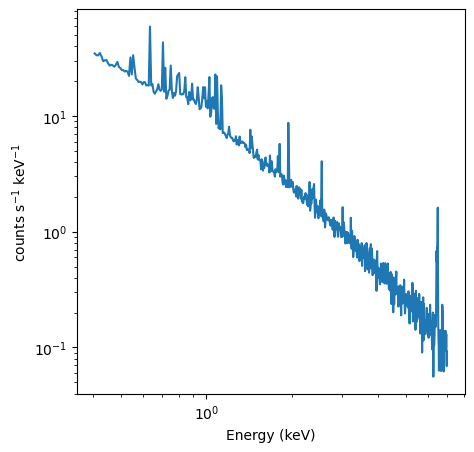

In [95]:
%run -i 'utils/scripts.py'

spectrum_name = '../data/eROSITA_30.0x30.0/photons/spectrum'+str(cl_num)+'.pha'

fit_spectra(spectrum_name)